In [22]:
from components.dataset_jo import Dataset_subjectDependent as MyDataset
from components.preprocessing import preprocess_interface, standardize, DE, ASYM, PCC, _parallel, convert_to_mne

dataset = MyDataset(dataset_path='data', lazyload=True)
lenght = 1
dataset.set_segment(7680//(128*60))
data, labels, groups = dataset.get_data('all', stimuli=1, return_type='numpy')
# X = DE(data, variant='asd')
# X = standardize(X)
print(data.shape)

Found: 32 files
(1280, 32, 7680)


In [23]:
import numpy as np
from scipy import signal

import logging
from multiprocessing import Pool
from itertools import combinations
import os
import mne

def _calculate_stft(signals: np.ndarray, sfreq: int):
    f_range, t_range, Z = signal.stft(signals, sfreq, nperseg=sfreq//10, nfft=sfreq)
    magnitude = np.abs(Z) 
    phase = np.angle(Z) #type: ignore
    return magnitude, phase, f_range, t_range

def _cal_plv(p_id, partial_data:np.ndarray) -> np.ndarray:
    plv = []
    # count = 0
    for index in range(partial_data.shape[0]):
        plv_epoch = []
        _,phase,_,_ = _calculate_stft(partial_data[index],128) #type: ignore
        for comb in combinations(list(range(partial_data.shape[1])), 2):
            # shape = (65,12)
            phase_a, phase_b = phase[comb[0]], phase[comb[1]]
            phase_diff = phase_a - phase_b
            # sum along the time size
            plv_ab = np.abs(np.average(np.exp(complex(0,1) * phase_diff), axis=1))
            plv_epoch.append(plv_ab)
        plv_epoch = np.vstack(plv_epoch)
        # print(plv_epoch.shape) => (300, 32, 65, 23)
        plv_epoch_5 = np.concatenate([ plv_epoch[:,0:4].mean(axis=1).reshape(-1,1),
                                        plv_epoch[:,4:8].mean(axis=1).reshape(-1,1),
                                        plv_epoch[:,8:12].mean(axis=1).reshape(-1,1),
                                        plv_epoch[:,12:30].mean(axis=1).reshape(-1,1),
                                        plv_epoch[:,30:65].mean(axis=1).reshape(-1,1)], axis=0)
        plv.append(np.expand_dims(plv_epoch_5, axis=0))
        # count += 1
        # if(count == 3): break
    # shape (496, 65)
    # 496 is number of pairs that is not duplicate
    # 65 is number of phase of frequencies
    plv = np.vstack( plv )
    return plv.squeeze()    

epochs = convert_to_mne(data)
epochs = mne.preprocessing.compute_current_source_density(epochs)
data = epochs.get_data()
del(epochs)
# def PLV(data: np.ndarray, variant:str) -> np.ndarray:
#     epochs = convert_to_mne(data)
#     epochs = mne.preprocessing.compute_current_source_density(epochs)
#     data = epochs.get_data()
#     del(epochs)
#     ans_list = _parallel(data, _cal_plv, n_jobs=os.cpu_count()) #type: ignore
#     return ans_list

Fitted sphere radius:         95.3 mm
Origin head coordinates:      -0.8 15.1 45.3 mm
Origin device coordinates:    -0.8 15.1 45.3 mm


In [7]:
print(data.shape)

(1280, 32, 7680)


In [25]:
plv = []
count = 0
for index in range(data.shape[0]):
    plv_epoch = []
    _,phase,_,_ = _calculate_stft(data[index],128) #type: ignore
    print(phase.shape)
    for comb in combinations(list(range(data.shape[1])), 2):
        # shape = (65,12)
        phase_a, phase_b = phase[comb[0]], phase[comb[1]]
        phase_diff = phase_a - phase_b
        # sum along the time size
        plv_ab = np.abs(np.average(np.exp(complex(0,1) * phase_diff), axis=1))
        plv_epoch.append(plv_ab)
    plv_epoch = np.vstack(plv_epoch)
    print(plv_epoch.shape) # => (496, 65)
    plv_epoch_5 = np.concatenate([ plv_epoch[:,0:4].mean(axis=1).reshape(-1,1),
                                    plv_epoch[:,4:8].mean(axis=1).reshape(-1,1),
                                    plv_epoch[:,8:12].mean(axis=1).reshape(-1,1),
                                    plv_epoch[:,12:30].mean(axis=1).reshape(-1,1),
                                    plv_epoch[:,30:65].mean(axis=1).reshape(-1,1)], axis=0).squeeze()
    print(plv_epoch_5.shape) # => (496 * 5)
    plv.append(np.expand_dims(plv_epoch_5, axis=0))
    count += 1
    if(count == 3): break
# shape (496, 65)
# 496 is number of pairs that is not duplicate
# 65 is number of phase of frequencies
plv = np.vstack( plv )
print(plv.shape)

(32, 65, 1281)
(496, 65)
(2480,)
(32, 65, 1281)
(496, 65)
(2480,)
(32, 65, 1281)
(496, 65)
(2480,)
(3, 2480)


In [2]:
import numpy as np
from scipy import signal
def _calculate_stft(signals: np.ndarray, sfreq: int):
    f_range, t_range, Z = signal.stft(signals, sfreq, nperseg=sfreq//10, nfft=sfreq)
    magnitude = np.abs(Z) 
    phase = np.angle(Z)
    return magnitude, phase, f_range, t_range


# import matplotlib.pyplot as plt
t = np.arange(0,1,1/128)
print(t.shape)
f = 60
data_time = np.sin(t * 2 * np.pi * f).reshape(1,1,-1) * 10
print(data_time.shape, data_time[0].shape)
# print(data_time.shape)
# data_freq = _calculate_fft(data_time, 128)

# freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
# print(data_freq.shape, freq_range.shape)
# plt.plot(freq_range, data_freq[0,0])
# data_freq[data_freq < 0.001] = 0
# print(data_freq)


data_freq, data_phase, f_range, t_range = _calculate_stft(data, 128)
print(data_freq.shape, data_phase.shape)

(128,)
(1, 1, 128) (1, 128)


NameError: name 'data' is not defined

In [34]:
from sklearn.model_selection import StratifiedGroupKFold,GridSearchCV,StratifiedKFold
n_split_outter = 10
cv_outter = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_1 = list(cv_outter.split(X, labels, groups))

cv_outter_2 = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_2 = list(cv_outter_2.split(X, labels, groups))

In [43]:
for a,b in zip(train_1, train_2):
    train = (a[0] == b[0]).all()
    test = (a[1] == b[1]).all()
    print(train == test)

True
True
True
True
True
True
True
True
True
True


In [55]:
import numpy as np
def _calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal, sfreq))
    # scale the result
    magnitude = magnitude / (sfreq/2)
    # Selecting the range
    magnitude = magnitude.T[:sfreq//2].T
    freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
    return magnitude



In [36]:
from components.preprocessing import convert_to_mne
import mne
epochs = convert_to_mne(data)
epochs = mne.preprocessing.compute_current_source_density(epochs)
data_time = epochs.get_data()  

Fitted sphere radius:         95.3 mm
Origin head coordinates:      -0.8 15.1 45.3 mm
Origin device coordinates:    -0.8 15.1 45.3 mm


(640,)
(1, 1, 64) (64,)
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]]]


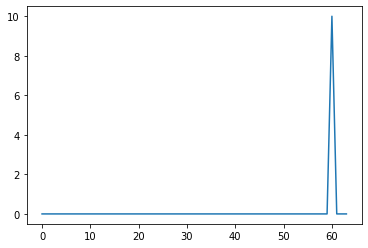

In [56]:
import matplotlib.pyplot as plt
t = np.arange(0,5,1/128)
print(t.shape)
f = 60
data_time = np.sin(t * 2 * np.pi * f).reshape(1,1,-1) * 10

data_freq = _calculate_fft(data_time, 128)

freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
print(data_freq.shape, freq_range.shape)
plt.plot(freq_range, data_freq[0,0])
data_freq[data_freq < 0.001] = 0
print(data_freq)


In [30]:
np.fft.fftfreq(128, d=1/128)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63., -64., -63.,
       -62., -61., -60., -59., -58., -57., -56., -55., -54., -53., -52.,
       -51., -50., -49., -48., -47., -46., -45., -44., -43., -42., -41.,
       -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,
        -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [34]:
data.shape, data_time.shape, data_freq.shape

((1280, 32, 7680), (1280, 32, 7680), (1280, 32, 128))

In [20]:
indices = np.array_split(np.arange(data.shape[0]), 10)

In [21]:
indices

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 1